In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

anon_pattern = (r'Patient Name|D.O.B|DOB|NHS|Referring Hospital|Referring Consultant')
end_pattern = (r'4ways|GMC|Dr\b|Radiologist|Sonographer|Radiographer|Cardiologist|[0-9]{5,7}')
def anonymise(report) :
    report = str(report)
    lines =  report.split('\n')
    processed_report = ''
    for i, l in enumerate(lines) :
        if re.findall(end_pattern, l, re.IGNORECASE) :
            return processed_report
        if i < len(lines)-1 :
            if re.findall(end_pattern, lines[i+1], re.IGNORECASE) :
                return processed_report
        if re.findall(anon_pattern, l, re.IGNORECASE) :
            pass
        else :
            processed_report+='\n'+l

    return processed_report

assert anonymise('Patient Name:  Brian\nDetails: HI\n\nDr David Barney\nRadiologist')  == '\nDetails: HI'
assert anonymise('Patient Name:  Brian\nDetails: HI\n\n AN other\nSonographer')  == '\nDetails: HI\n'
reptest = 'Clinical Information: Pneumothorax? \nI note a CTPA has been requested.\nAlfred Hitchcock\nReporting Radiographer\nRA67676'
assert anonymise(reptest) == '\nClinical Information: Pneumothorax? \nI note a CTPA has been requested.'
               

In [2]:
def within_time_interval(t, reference_time, delta, direction='forwards') :
    ''' 
    Test if time t lies within an interval of width |delta| (days) of reference_time
    Allowable directions are 'forwards' ie if t is later than reference_time by
    no more than delta, 'backwards' if t is earlier than reference_time by no more
    than delta, or 'centred' ie |t-reference_time|<delta/2
    t and reference_time are datetime objects, delta is a numeric type
    '''
    delta = abs(delta)
    one_day = datetime.timedelta(days=1)
    zero_time = datetime.timedelta(days=0)
    dt = pd.to_datetime(t, dayfirst=True)-pd.to_datetime(reference_time, dayfirst=True)
    if direction == 'forwards':
        return (dt > zero_time) and (dt < delta*one_day)
    dt = -dt
    if direction == 'backwards':
        return (dt > zero_time) and (dt < delta*one_day)
    if direction == 'centred' :
        return abs(dt) < delta*one_day/2
    print ("Invalid 'direction' argument in function 'within_time_interval'")
    raise SystemExit(0)

assert within_time_interval(pd.to_datetime('2/1/2018'), pd.to_datetime('1/1/2018'), 32.0, direction='forwards')
assert ~within_time_interval(pd.to_datetime('2/1/2018'), pd.to_datetime('1/1/2018'), 30.0, direction='forwards')
assert within_time_interval(pd.to_datetime('1/1/2018'), pd.to_datetime('2/1/2018'), 32.0, direction='backwards')
assert ~within_time_interval(pd.to_datetime('1/1/2018'), pd.to_datetime('2/1/2018'), 30.0, direction='backwards')
assert within_time_interval(pd.to_datetime('2/1/2018'), pd.to_datetime('1/1/2018'), 64.0, direction='centred')
assert ~within_time_interval(pd.to_datetime('2/1/2018'), pd.to_datetime('1/1/2018'), 60.0, direction='centred')  
    

/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risData['IP within 1 day'].loc[idx] = 'Within 1 day'
/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risData['IP report within 4h'].loc[idx] = 'Within 4h'
/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risData['IP within 1 day'].loc[idx] = 'Within 1 day'
/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risData['IP report within 4h'].loc[idx] = 'Exceeded 4h'
/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risData['IP within 1 day'].loc[idx] = 'Within 1 day'
/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risData['IP report within 4h'].loc[idx] = 'Within 4h'
/var/folders/3x/hflj9l0976lf2fwv4ksx67mw0000gn/T/ipykernel_24443/1232733913.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

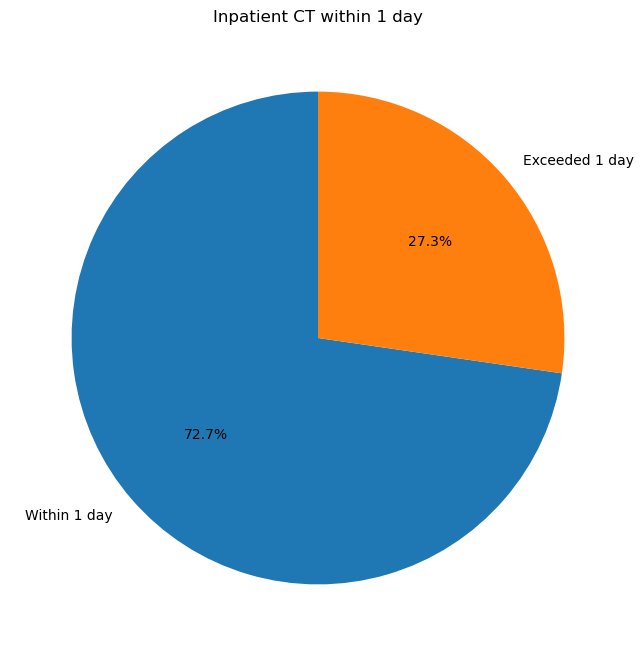

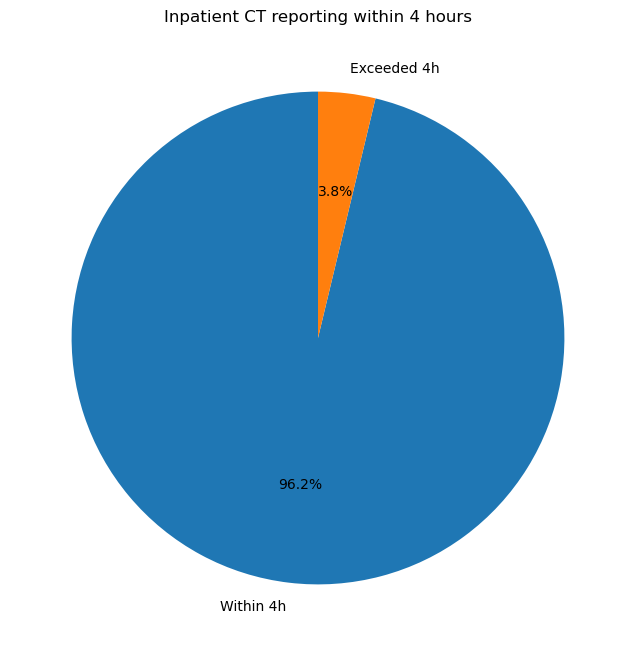

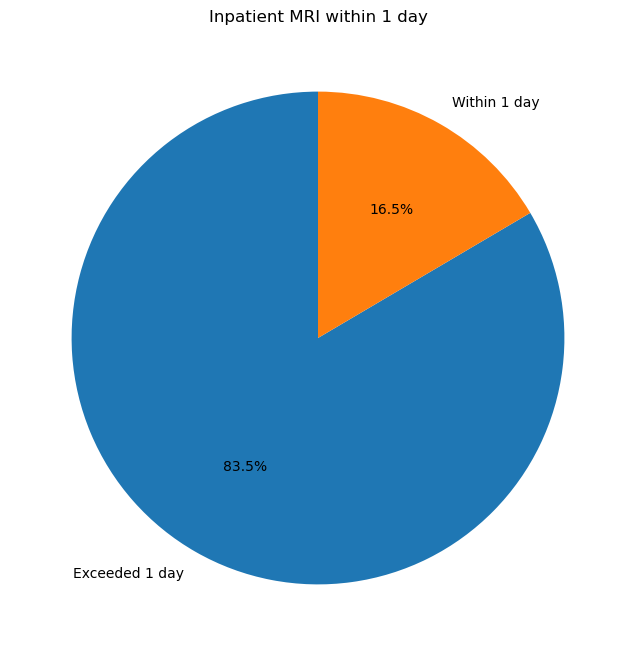

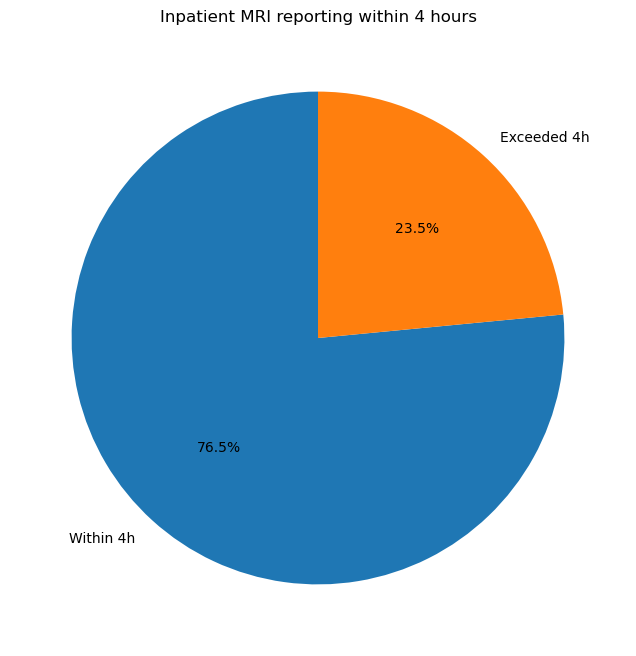

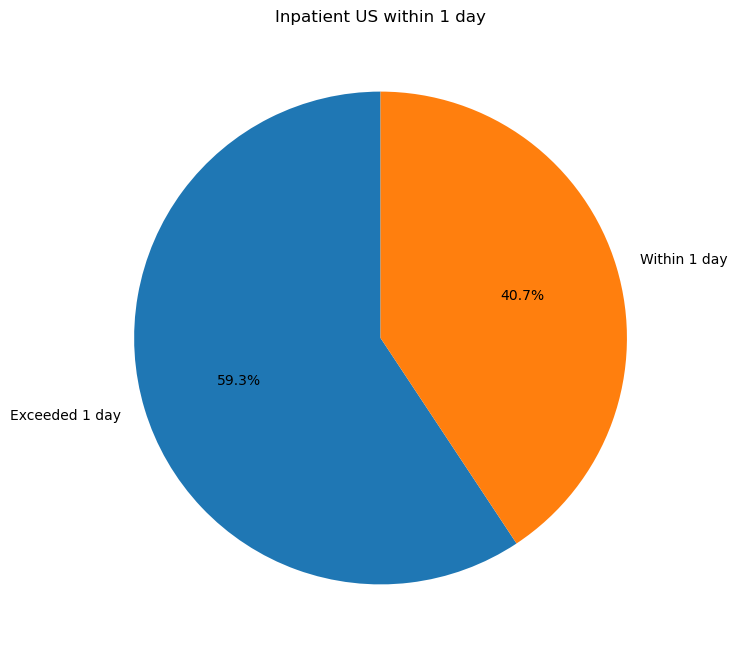

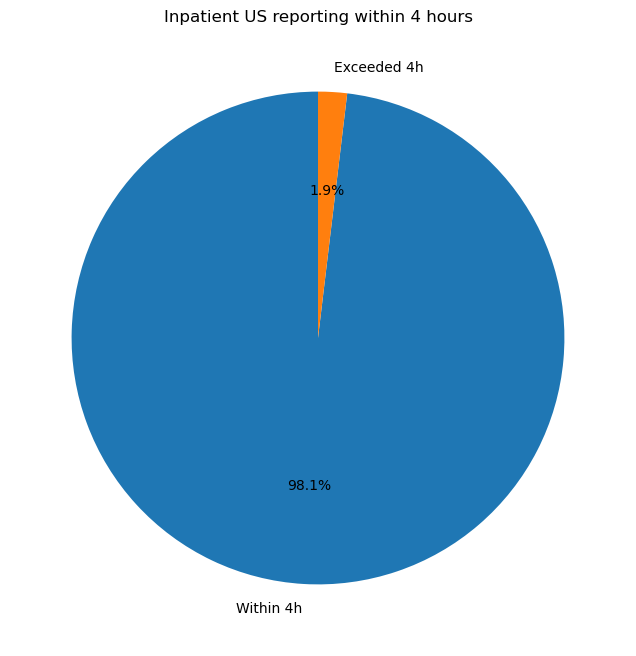

In [3]:
modalities = ['CT', 'MRI', 'US']

for modality in modalities :
    
    risData = pd.read_csv('../data/Jan24_1.csv', low_memory=False, parse_dates=True, dayfirst=True)
    risData = risData.drop_duplicates(subset=["Accession No"])
    risData = risData[risData['Is Addendum Report'] == 'No']
    risData = risData[risData['Visit Type'] == 'In Patient']
    risData = risData[risData['Modality'] == modality]
    
    risData['IP within 1 day'] = ''
    risData['IP report within 4h'] = ''

    for idx, row in risData.iterrows() :
        less_than_day = within_time_interval(row['Authorised Date'], row['Requested Date'], 1.0)
        if less_than_day :
            risData['IP within 1 day'].loc[idx] = 'Within 1 day'
        else :
            risData['IP within 1 day'].loc[idx] = 'Exceeded 1 day'
        
        rep_less_than_4h = within_time_interval(row['Authorised Date'], row['Completed Date'], 4.0/24)
        if rep_less_than_4h :
            risData['IP report within 4h'].loc[idx] = 'Within 4h'
        else :
            risData['IP report within 4h'].loc[idx] = 'Exceeded 4h'
        
        
    value_counts = risData['IP within 1 day'].value_counts()

# Plotting a pie chart with angles proportional to the counts
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Inpatient {modality} within 1 day')
    plt.savefig(f'../assets/images/IP{modality}_imaging_24h.png')

    value_counts = risData['IP report within 4h'].value_counts()

# Plotting a pie chart with angles proportional to the counts
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Inpatient {modality} reporting within 4 hours')
    plt.savefig(f'../assets/images/IP{modality}_reporting_4h.png')
